In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data,filters
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
from math import floor, ceil
import pandas as pd
import cv2
import os
import math

# Question 1
## 1a

In [2]:
def H_matrix(theta, s, x0, y0, t0=None, t1=None):
    return np.array([[s*math.cos(theta),-s*math.sin(theta), -(math.cos(theta)*x0+ math.sin(theta)*y0-x0)],
                    [s*math.sin(theta),s*math.cos(theta),-(math.sin(theta)*x0+ math.cos(theta)*y0-x0)],
                    [0,0,1]])
def H_matrix_t(theta, s, x0, y0, t0, t1):
    return np.array([[s*math.cos(theta),-s*math.sin(theta),t1],
                    [s*math.sin(theta),s*math.cos(theta),t1],
                    [0,0,1]])

## 1b
Apply the homography H from part (a) to a colour image of your choosing, for two or three different
choices of θ and s. You will find a document in the accompanying material detailing how an image
can be transformed with a given homography.

In [3]:
def apply_homography(a, h):
    r, c, col = np.shape(a)
    # Determine size of output image by forward-transforming the four corners of A
    p1_h, p2_h, p3_h, p4_h = np.array([[0], [0], [1]], dtype=np.float), \
                             np.array([[c - 1], [0], [1]], dtype=np.float), \
                             np.array([[0], [r - 1], [1]], dtype=np.float), \
                             np.array([[c - 1], [r - 1], [1]], dtype=np.float)

    # Apply homography on each point
    p1, p2, p3, p4 = np.dot(h, p1_h), np.dot(h, p2_h), np.dot(h, p3_h), np.dot(h, p4_h)
    p1, p2, p3, p4 = p1 / p1[2, 0], p2 / p2[2, 0], p3 / p3[2, 0], p4 / p4[2, 0]

    # Get new min and max from each axis
    min_x = floor(min([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    max_x = ceil(max([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    min_y = floor(min([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))
    max_y = ceil(max([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))

    # Obtain new row and column
    nr, nc = max_y - min_y + 1, max_x - min_x + 1

    # Initialize new array with white background
    b = np.zeros([int(nr), int(nc), int(col)]) + 255

    # Pre-compute inverse of H
    h_inv = np.linalg.inv(h)

    points = []

    # Define function on coordinates
    for y in range(int(nr)):
        for x in range(int(nc)):
            p = np.array([[x + min_x], [y + min_y], [1]])
            pp = np.dot(h_inv, p)

            # De-homogenize
            xp, yp = pp[0, 0] / pp[2, 0], pp[1, 0] / pp[2, 0]

            # Interpolate
            xpf, ypf = int(floor(xp)), int(floor(yp))
            xpc, ypc = xpf + 1, ypf + 1

            # Placing the pixels in new image
            if (xpf >= 0) and (xpc < c) and (ypf >= 0) and (ypc < r):
                b[y, x, :] = ((xpc - xp) * (ypc - yp) * a[ypf, xpf, :]
                              + (xpc - xp) * (yp - ypf) * a[ypc, xpf, :]
                              + (xp - xpf) * (ypc - yp) * a[ypf, xpc, :]
                              + (xp - xpf) * (yp - ypf) * a[ypc, xpc, :])
                points.append([y, x])
    return b.astype(np.uint8)

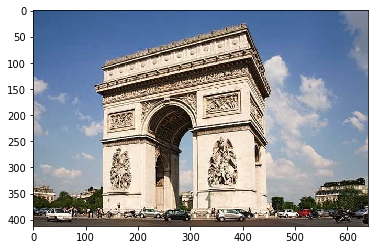

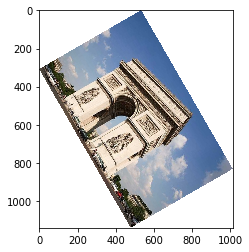

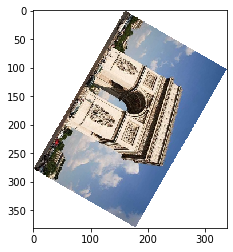

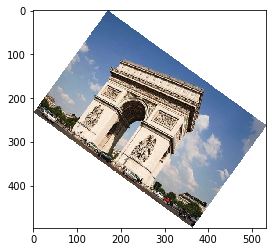

In [4]:
theta = np.pi/3
s = 1.5
H = H_matrix(theta,s,0,0)
A = plt.imread("arc.jpg")
plt.imshow(A)
plt.show()

B = apply_homography(A, H)
plt.imshow(B)
plt.show()

theta = 2*np.pi/3
s = 0.5
H = H_matrix(theta,s,0,0)
B = apply_homography(A, H)
plt.imshow(B)
plt.show()

theta = 0.2*np.pi
s = 0.7
H = H_matrix(theta,s,0,0)
B = apply_homography(A, H)
plt.imshow(B)
plt.show()

## 1c
If the procedure in that document is followed, why would different values for the translation component
in H (the last column’s first two entries) have no effect on the output image? Also, if θ > 0, why is
the image rotated clockwise even though the form of R suggests counterclockwise rotation?

# Question 2
## 2a
Paste a poster of your favourite movie onto the side of the building in griest.jpg. More specifically,
manually select the four corners of the building to which the corners of the poster image should map,
calculate the appropriate homography, apply the homography to the poster image, and overlay the result.

The transformed image will contain parts with no image data that we want to ignore, and the image origin
may shift. Explain how you addressed these two issues.

Also, if we follow the interpolation procedure in that document on applying homographies to images, it
turns out that our input (untransformed) poster image should be more-or-less similar in size to the desired
output (the transformed image). If the input is much larger, we may get unwanted “aliasing” artefacts
in the output. Experiment with this idea, and include in your report a short description of the issue of
aliasing in image interpolation.

In [29]:
def find_homography(pts_src, pts_dest):
    """
    Find Homography from src to dest
    """
    x1 = pts_src[0][0]
    x2 = pts_src[1][0]
    x3 = pts_src[2][0]
    x4 = pts_src[3][0]
    y1 = pts_src[0][1]
    y2 = pts_src[1][1]
    y3 = pts_src[2][1]
    y4 = pts_src[3][1]
    x_1 = pts_dest[0][0]
    x_2 = pts_dest[1][0]
    x_3 = pts_dest[2][0]
    x_4 = pts_dest[3][0]
    y_1 = pts_dest[0][1]
    y_2 = pts_dest[1][1]
    y_3 = pts_dest[2][1]
    y_4 = pts_dest[3][1]

    A = np.array([
    [x1,y1,1,0,0,0,-x_1*x1, -x_1*y1, -x_1],
    [0,0,0,x1,y1,1,-y_1*x1, -y_1*y1, -y_1],
    [x2,y2,1,0,0,0,-x_2*x2, -x_2*y2, -x_2],
    [0,0,0,x2,y2,1,-y_2*x2, -y_2*y2, -y_2],
    [x3,y3,1,0,0,0,-x_3*x3, -x_3*y3, -x_3],
    [0,0,0,x3,y3,1,-y_3*x3, -y_3*y3, -y_3],
    [x4,y4,1,0,0,0,-x_4*x4, -x_4*y4, -x_4],
    [0,0,0,x4,y4,1,-y_4*x4, -y_4*y4, -y_4],
    ])
    
    _,_,V = np.linalg.svd(A)
    h = V[:,V.shape[1] - 1]
    
    H = np.array([
        [h[0],h[1],h[2]],
        [h[3],h[4],h[5]],
        [h[6],h[7],h[8]],
    ])
    print(H)
    return H

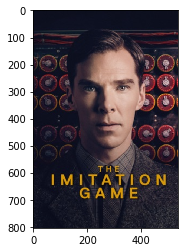

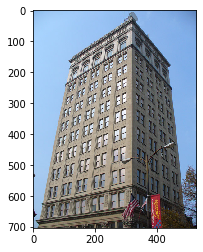

[[ 2.52953721e-03 -1.91947562e-03  1.86351255e-01]
 [ 8.73811026e-01 -2.45971845e-01 -3.57206360e-01]
 [-1.16640315e-01  1.85647262e-07 -3.73126416e-03]]
[[ 1.26306791e-03 -9.57205429e-04  6.26466500e-02]
 [ 1.38667176e-01 -5.45302894e-01 -7.86145062e-01]
 [-2.47893269e-01  4.62325173e-08 -3.73128456e-03]]
[[ 6.31109451e-04 -4.77971318e-04  2.88595477e-02]
 [ 4.78364407e-02 -2.22005773e-01 -7.89746270e-01]
 [-5.69103258e-01  1.15361510e-08 -3.73128964e-03]]


In [56]:
poster_small = plt.imread("poster.jpg")
poster_medium = cv2.resize(plt.imread("poster.jpg"),None,fx=2,fy=2)
poster_large = cv2.resize(plt.imread("poster.jpg"),None,fx=4,fy=4)
building = plt.imread("griest.jpg")
plt.imshow(poster_medium)
plt.show()
plt.imshow(building)
plt.show()

building_points = np.asarray([
            [104, 247],
            [315, 120],
            [32, 622],
            [313, 564],
        ])
# Small homograhpy
points_small = np.asarray([
           [0,0],
           [poster_small.shape[0]-1, 0],
           [0, poster_small.shape[1]-1],
           [poster_small.shape[0]-1, poster_small.shape[1]-1]
          ])
H_small = find_homography(points_small, building_points)
# Medium homograhpy
points_medium = np.asarray([
           [0,0],
           [poster_medium.shape[0]-1, 0],
           [0, poster_medium.shape[1]-1],
           [poster_medium.shape[0]-1, poster_medium.shape[1]-1]
          ])
H_medium = find_homography(points_medium, building_points)
# Large homograhpy
points_large = np.asarray([
           [0,0],
           [poster_large.shape[0]-1, 0],
           [0, poster_large.shape[1]-1],
           [poster_large.shape[0]-1, poster_large.shape[1]-1]
          ])
H_large = find_homography(points_large, building_points)


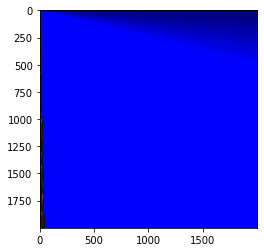

In [55]:
''' 
The calculated homography can be used to warp 
the source image to destination. Size is the 
size (width,height) of im_dst
'''
im_dst = cv2.warpPerspective(poster_medium, H_medium, (2000,2000))
plt.imshow(im_dst)

[[ 1.88968429e-01 -1.49559582e-01  1.04000000e+02]
 [-1.86269751e-01  4.09758051e-01  2.47000000e+02]
 [-2.34273662e-04 -4.68129468e-04  1.00000000e+00]]
[[-2.35149982e-01  4.12431872e-04 -4.03496160e+00]
 [-2.25818734e+01 -1.79420386e+00 -1.11870574e+00]
 [ 1.56222482e+01 -2.74227370e-02  6.42588119e-02]]
[[  0   0]
 [803   0]
 [  0 535]
 [803 535]]
(804, 536, 3)


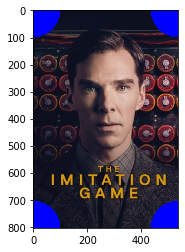

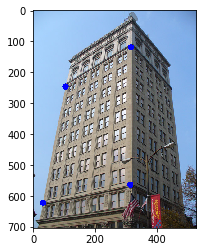

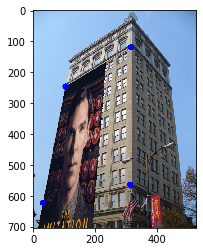

In [57]:
# Read source image.
im_src = poster_medium
# Four corners of the book in source image
pts_src = points_medium
 
# Read destination image.
im_dst = building
# Four corners of the book in destination image.
pts_dst = building_points
 
# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)
print(h)
print(H_medium)
     
# Warp source image to destination based on homography
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
     
mask = im_out[:,:,:] == [0,0,0]
un_mask = np.invert(mask)
im_out[mask] = building[mask]

print(pts_src)
print(im_src.shape)
for p in pts_src:
    cv2.circle(im_src,(p[1],p[0]), 100, (0,0,255), -1)

for p in pts_dst:
    cv2.circle(im_out,(p[0],p[1]), 10, (0,0,255), -1)
    cv2.circle(im_dst,(p[0],p[1]), 10, (0,0,255), -1)

# Display images
plt.imshow(im_src)
plt.show()
plt.imshow(building)
plt.show()
plt.imshow(im_out)
plt.show()

In [ ]:
import cv2
import numpy as np

# Defining variables to store coordinates where the second image has to be placed
positions=[] 
positions2=[]
count=0

# Mouse callback function
def draw_circle(event,x,y,flags,param):
    global positions,count
    # If event is Left Button Click then store the coordinate in the lists, positions and positions2
    if event == cv2.EVENT_LBUTTONUP:
        cv2.circle(building,(x,y),2,(255,0,0),-1)
        positions.append([x,y])
        if(count!=3):
            positions2.append([x,y])
        elif(count==3):
            positions2.insert(2,[x,y])
        count+=1
        
# Reading the two images and storing it in variables img and dp
building = cv2.imread('griest.jpeg')
dp = cv2.imread('poster.jpg')

# Defing a window named 'image'
cv2.namedWindow('image')

cv2.setMouseCallback('image',draw_circle)

while(True):
    cv2.imshow('image',building)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()

height, width = building.shape[:2]
h1,w1 = dp.shape[:2]

pts1=np.float32([[0,0],[w1,0],[0,h1],[w1,h1]])
pts2=np.float32(positions)


h, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)

height, width, channels = building.shape
im1Reg = cv2.warpPerspective(dp, h, (width, height))

mask2 = np.zeros(building.shape, dtype=np.uint8)

roi_corners2 = np.int32(positions2)

channel_count2 = building.shape[2]  
ignore_mask_color2 = (255,)*channel_count2

cv2.fillConvexPoly(mask2, roi_corners2, ignore_mask_color2)

mask2 = cv2.bitwise_not(mask2)
masked_image2 = cv2.bitwise_and(building, mask2)

#Using Bitwise or to merge the two images
final = cv2.bitwise_or(im1Reg, masked_image2)
cv2.imwrite('final.png',final)